In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision as tv

import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import tqdm

In [2]:
class Dataset2class(torch.utils.data.Dataset):
    def __init__(self, path1:str, path2:str):
        super().__init__()

        self.path1 = path1
        self.path2 = path2

        self.list1 = sorted(os.listdir(self.path1))
        self.list2 = sorted(os.listdir(self.path2))

    def __len__(self):
        return len(self.list1) + len(self.list2)

    def __getitem__(self, index):
        class_id = 0 if index % self.__len__() < len(self.list1) else 1
        index %= len(self.list1)

        img_name = (self.list2 if class_id else self.list1)[index]
        img_path = os.path.join(self.path2 if class_id else self.path1, img_name)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = img.astype(np.float32)
        img = img / 255.0

        img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

        img.transpose((2, 0, 1))

        t_img = torch.from_numpy(img)
        t_class_id = torch.tensor(class_id)

        return {'img': t_img, 'label': t_class_id}

In [3]:
train_cats_path = 'datasets/cats/'
train_dogs_path = 'datasets/dogs/'

train_ds = Dataset2class(train_cats_path, train_dogs_path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


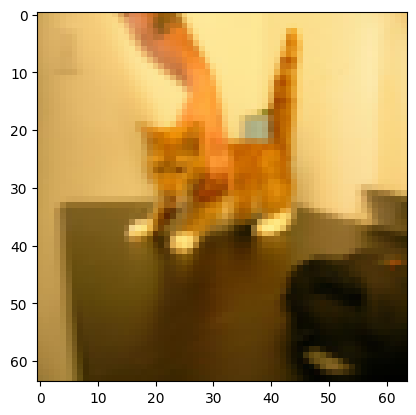

In [4]:
plt.imshow(train_ds[0]['img'])

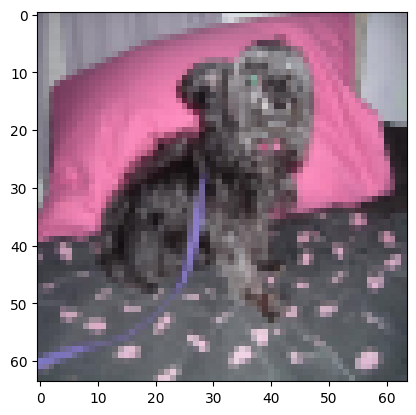

In [5]:
plt.imshow(train_ds[12500]['img'])

In [6]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(
    train_ds, 
    batch_size=batch_size, 
    num_workers=1, 
    shuffle=True,
    drop_last=True
)

test_loader = torch.utils.data.DataLoader(
    train_ds, 
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.act = nn.LeakyReLU(0.2)
        self.maxpool = nn.MaxPool2d(2, 2)

        self.conv0 = nn.Conv2d(3, 32, 3, stride=1, padding=0)
        self.conv1 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=0)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=1, padding=0)

        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64, 10)
        self.linear2 = nn.Linear(10, 2)
        
    def forward(self, x):
        print(x.shape)

        out = self.conv0(x)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv1(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv3(out)
        out = self.act(out)
        out = self.maxpool(out)

        out = self.conv4(out)
        out = self.act(out)

        out = self.adaptivepool(out)
        out = self.flatten(out)
        out = self.linear1(out)
        out = self.act(out)
        out = self.linear2(out)

        print(out.shape)

        return out

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
model = ConvNet()

In [19]:
model

ConvNet(
  (act): LeakyReLU(negative_slope=0.2)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=64, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=2, bias=True)
)

In [20]:
count_parameters(model)

103168

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

In [22]:
def accuracy(pred, label):
    answer = F.softmax(pred.detach().numpy().argmax() == label.numpy().argmax())
    return answer.mean()